torch version:  2.6.0
device:  mps
Loaded 90 training images with resolution 160000 pixels
Loaded 10 test images
Starting warmup training with cropped images...


100%|██████████| 3516/3516 [11:11<00:00,  5.23it/s]


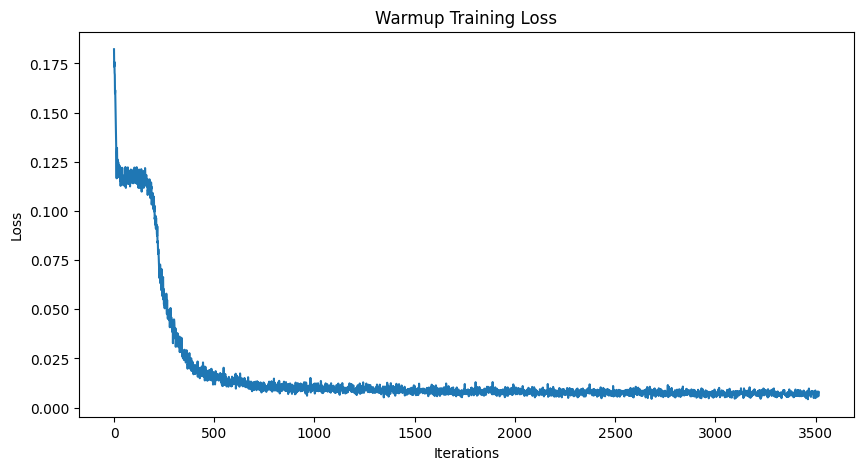

Starting main training with full images...


100%|██████████| 14063/14063 [55:11<00:00,  4.25it/s]


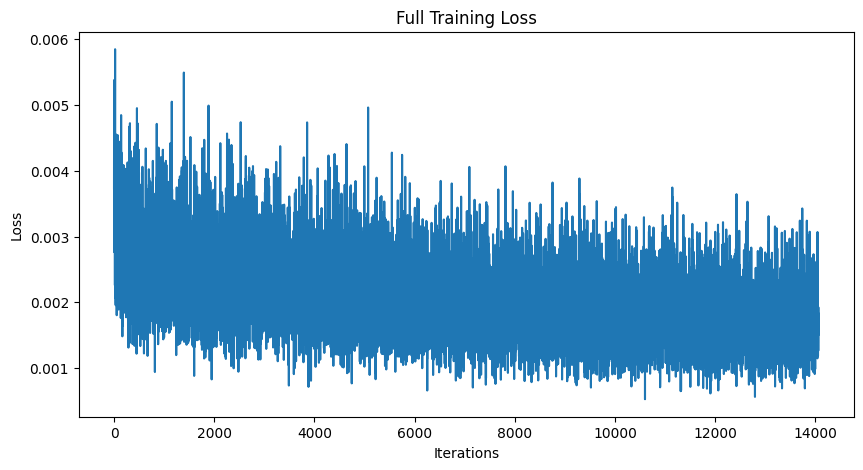

Model weights saved to 'nerf_model_weights.pth'
Ray origins min: -3.3348591327667236, max: 3.8433210849761963
Ray directions min: -0.9982403516769409, max: 0.9230102300643921
Ray direction lengths: min=0.9999998211860657, max=1.0000001192092896


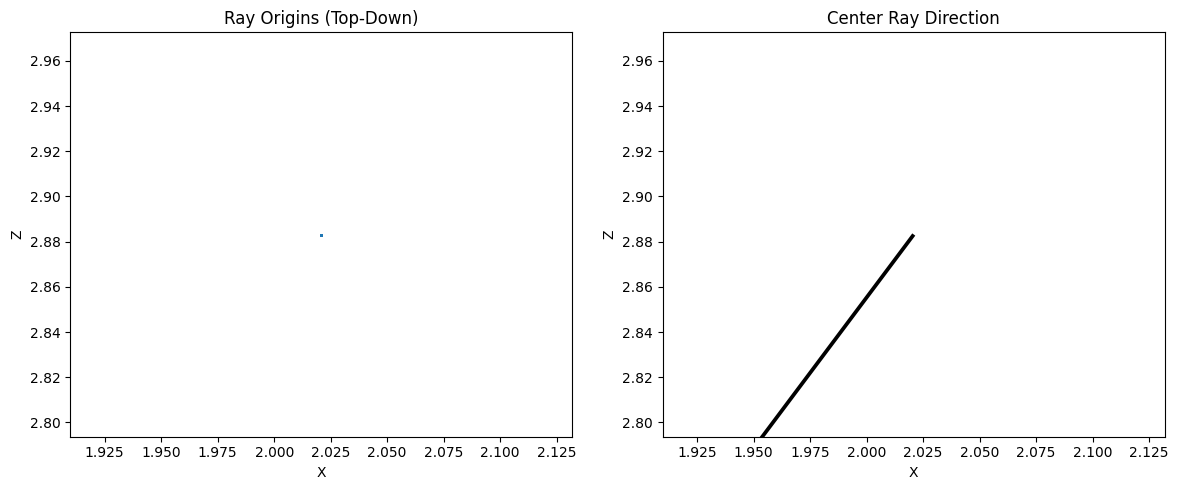

Rendering test image...
Test image 0: Ray origins shape: torch.Size([160000, 3])
Ray origins range: min=1.9042, max=2.8832
First render batch stats: min=0.9358, max=1.0000


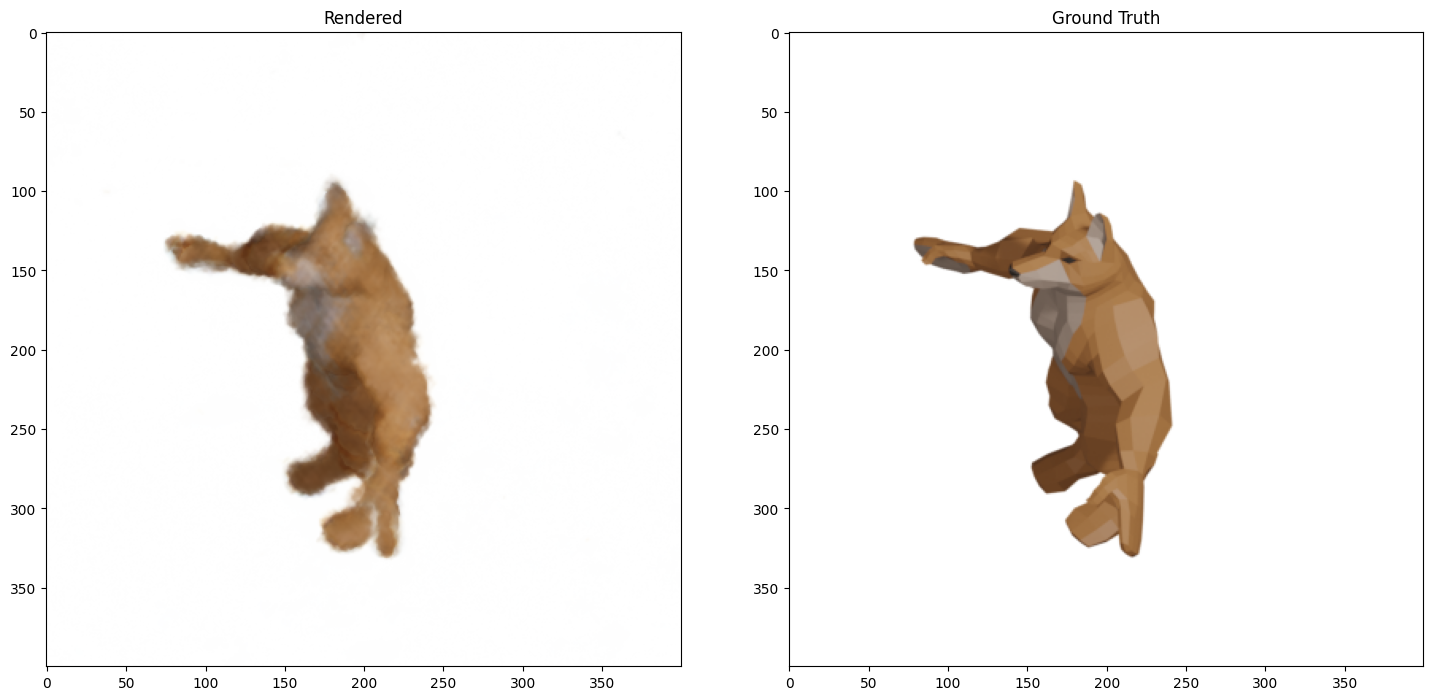

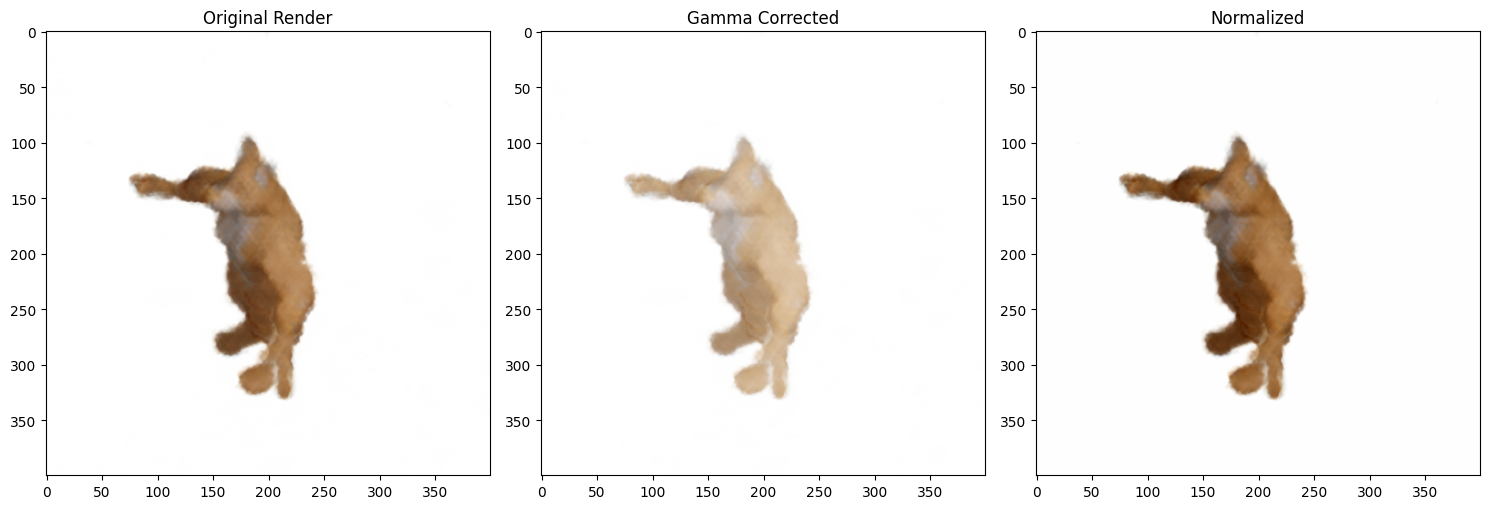

If the image is still white, try adjusting tn/tf parameters or increasing nb_bins


In [8]:
import torch
import torch.nn as nn
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

print("torch version: ", torch.__version__)
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device: ", device)

# Set the near and far thresholds for rendering
# These values need to match the scale in transforms.json
# For the fox dataset in transforms.json, the cameras are approximately at distance 3-4 units
tn = 0.1  # Near threshold - much closer to capture details near camera
tf = 6.0  # Far threshold - covers the full scene

# Load training rays from transforms.json
batch_size = 1024
o, d, target_px_values = get_rays('fox', mode='train')
print(f"Loaded {o.shape[0]} training images with resolution {o.shape[1]} pixels")

# Create data loaders for full and cropped images
# Force float32 to avoid MPS issues
dataloader = DataLoader(torch.cat((
    torch.from_numpy(o.astype(np.float32)).reshape(-1, 3),
    torch.from_numpy(d.astype(np.float32)).reshape(-1, 3),
    torch.from_numpy(target_px_values.astype(np.float32)).reshape(-1, 3)), dim=1),
    batch_size=batch_size, shuffle=True)

# For warmup training, use a center crop of the images
img_size = int(np.sqrt(o.shape[1]))  # Assuming square images
o_reshaped = o.reshape(o.shape[0], img_size, img_size, 3)
d_reshaped = d.reshape(d.shape[0], img_size, img_size, 3)
target_reshaped = target_px_values.reshape(target_px_values.shape[0], img_size, img_size, 3)

# Create a center crop (adjust crop size as needed)
crop_start = img_size // 4
crop_end = img_size - crop_start
o_cropped = o_reshaped[:, crop_start:crop_end, crop_start:crop_end, :].astype(np.float32)
d_cropped = d_reshaped[:, crop_start:crop_end, crop_start:crop_end, :].astype(np.float32)
target_cropped = target_reshaped[:, crop_start:crop_end, crop_start:crop_end, :].astype(np.float32)

dataloader_warmup = DataLoader(torch.cat((
    torch.from_numpy(o_cropped).reshape(-1, 3),
    torch.from_numpy(d_cropped).reshape(-1, 3),
    torch.from_numpy(target_cropped).reshape(-1, 3)), dim=1),
    batch_size=batch_size, shuffle=True)

# Load test rays for evaluation
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')
print(f"Loaded {test_o.shape[0]} test images")

# Initialize the NeRF model with more capacity
model = Nerf(hidden_dim=256, Lpos=10, Ldir=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)  # Lower learning rate for stability
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 4, 6], gamma=0.5)

# Training: First warmup with cropped images
print("Starting warmup training with cropped images...")
nb_bins = 100  # Number of sample points along each ray
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.figure(figsize=(10, 5))
plt.plot(training_loss)
plt.title("Warmup Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# Continue training with full images
print("Starting main training with full images...")
nb_epochs = 1
nb_bins = 128  # Increase the number of bins for better sampling
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.figure(figsize=(10, 5))
plt.plot(training_loss)
plt.title("Full Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# Save a checkpoint after each epoch to monitor progress
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_loss': training_loss,
    'tn': tn,
    'tf': tf,
    'nb_bins': nb_bins
}, 'nerf_checkpoint.pth')

# Save the model weights
torch.save(model.state_dict(), 'nerf_model_weights.pth')
print("Model weights saved to 'nerf_model_weights.pth'")

# Render a test image for visual evaluation
def visualize_test_image(idx=0):
    with torch.no_grad():
        test_batch_size = 4096
        test_idx = idx
        test_h = int(np.sqrt(test_o.shape[1]))
        test_w = test_h
        
        # Get rays for a single test image - explicitly cast to float32
        o_test = torch.from_numpy(test_o[test_idx].astype(np.float32)).to(device)
        d_test = torch.from_numpy(test_d[test_idx].astype(np.float32)).to(device)
        
        # Print information about the test rays
        print(f"Test image {idx}: Ray origins shape: {o_test.shape}")
        print(f"Ray origins range: min={o_test.min().item():.4f}, max={o_test.max().item():.4f}")
        
        # Render in batches to avoid OOM
        img_rendered = []
        for i in range(0, test_h * test_w, test_batch_size):
            end = min(i + test_batch_size, test_h * test_w)
            rendered_batch = rendering(model, o_test[i:end], d_test[i:end], tn, tf, nb_bins, device)
            img_rendered.append(rendered_batch)
            
            # Check if rendering is producing reasonable values
            if i == 0:
                print(f"First render batch stats: min={rendered_batch.min().item():.4f}, max={rendered_batch.max().item():.4f}")
            
        img_rendered = torch.cat(img_rendered, dim=0)
        img_rendered = img_rendered.reshape(test_h, test_w, 3).cpu().numpy()
        
        # Get the ground truth image
        img_truth = test_target_px_values[test_idx].reshape(test_h, test_w, 3)
        
        # Display rendered vs ground truth
        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(np.clip(img_rendered, 0, 1))  # Clip values to valid range
        plt.title("Rendered")
        plt.subplot(1, 2, 2)
        plt.imshow(img_truth)
        plt.title("Ground Truth")
        plt.tight_layout()
        plt.show()
        
        # Also try showing the render with different gamma correction in case it's just very dark
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(np.clip(img_rendered, 0, 1))
        plt.title("Original Render")
        
        plt.subplot(1, 3, 2)
        plt.imshow(np.clip(img_rendered ** 0.45, 0, 1))  # Gamma correction
        plt.title("Gamma Corrected")
        
        plt.subplot(1, 3, 3)
        # Normalize to use full dynamic range
        normalized = (img_rendered - img_rendered.min()) / (img_rendered.max() - img_rendered.min() + 1e-8)
        plt.imshow(normalized)
        plt.title("Normalized")
        
        plt.tight_layout()
        plt.show()
        
        # Save the rendered image - this can help diagnose issues
        plt.imsave(f'test_render_{idx}.png', np.clip(img_rendered, 0, 1))

# Add a debugging function to check the ray generation
def debug_ray_generation():
    # Load a single test image and visualize the ray distribution
    test_idx = 0
    test_h = int(np.sqrt(test_o.shape[1]))
    test_w = test_h
    
    # Print ray statistics
    print(f"Ray origins min: {test_o.min()}, max: {test_o.max()}")
    print(f"Ray directions min: {test_d.min()}, max: {test_d.max()}")
    
    # Check if ray directions are normalized
    ray_lengths = np.linalg.norm(test_d, axis=-1)
    print(f"Ray direction lengths: min={ray_lengths.min()}, max={ray_lengths.max()}")
    
    # Visualize ray origins and directions
    plt.figure(figsize=(12, 5))
    
    # Plot ray origins
    plt.subplot(1, 2, 1)
    plt.scatter(test_o[test_idx, ::100, 0], test_o[test_idx, ::100, 2], alpha=0.5, s=1)
    plt.title("Ray Origins (Top-Down)")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.axis('equal')
    
    # Plot ray directions (from the center pixel)
    center_idx = test_h // 2 * test_w + test_w // 2
    plt.subplot(1, 2, 2)
    plt.quiver(test_o[test_idx, center_idx, 0].astype(np.float32), 
               test_o[test_idx, center_idx, 2].astype(np.float32),
               test_d[test_idx, center_idx, 0].astype(np.float32), 
               test_d[test_idx, center_idx, 2].astype(np.float32),
               angles='xy', scale_units='xy', scale=0.1)
    plt.title("Center Ray Direction")
    plt.xlabel("X")
    plt.ylabel("Z")
    plt.axis('equal')
    
    plt.tight_layout()
    plt.show()

# Debug ray generation
debug_ray_generation()

# Visualize a test image
print("Rendering test image...")
visualize_test_image(0)
print("If the image is still white, try adjusting tn/tf parameters or increasing nb_bins")

In [9]:
import torch
import numpy as np
from nerfvis import scene
from model import Nerf

# Define device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the model with the SAME architecture as the trained model
# Match these parameters to those used during training
model = Nerf(hidden_dim=256, Lpos=10, Ldir=4).to(device)

# Load the saved weights
model.load_state_dict(torch.load('nerf_model_weights.pth', map_location=device))
model.eval()

# Create a scene
scene.set_title("NeRF Visualization")

# Add coordinate axes for reference
scene.add_axes("axes", length=1.0)

# Define a 3D grid of points to sample your NeRF
# Use a smaller resolution if you encounter memory issues
resolution = 128  # Number of points per dimension (reduced from 512 for faster processing)
# Adjust the sampled area to match the scene's bounding box
x = np.linspace(-1, 5, resolution)
y = np.linspace(-1, 5, resolution)
z = np.linspace(-1, 5, resolution)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
points = np.stack([xx.flatten(), yy.flatten(), zz.flatten()], axis=-1).astype(np.float32)  # Explicitly use float32

# For each point, we'll use multiple viewing directions
num_directions = 6
directions = []
for i in range(num_directions):
    # Create evenly distributed viewing directions
    theta = np.pi * i / num_directions
    phi = 2 * np.pi * i / num_directions
    dx = np.sin(theta) * np.cos(phi)
    dy = np.sin(theta) * np.sin(phi)
    dz = np.cos(theta)
    directions.append([dx, dy, dz])

directions = np.array(directions, dtype=np.float32)  # Explicitly use float32
directions_tensor = torch.tensor(directions, dtype=torch.float32, device=device)

# Evaluate NeRF at these points and directions
print("Evaluating NeRF at grid points...")
valid_points = []
valid_colors = []

batch_size = 2000  # Reduced batch size for MPS memory constraints
num_batches = (points.shape[0] + batch_size - 1) // batch_size

# Density threshold - adjust this if you're getting too many or too few points
threshold = 0.1  # Start with a lower threshold

with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, points.shape[0])
        batch_points = torch.tensor(points[start_idx:end_idx], dtype=torch.float32, device=device)
        
        batch_colors_list = []
        batch_densities_list = []
        
        for direction in directions_tensor:
            # Expand direction to match the batch size
            batch_dirs = direction.expand(batch_points.size(0), -1)
            
            # Get model output
            colors, density = model.intersect(batch_points, batch_dirs)  # Using intersect method
            
            batch_colors_list.append(colors)
            batch_densities_list.append(density)
        
        # Average colors across different view directions
        avg_colors = torch.stack(batch_colors_list).mean(dim=0)
        # Use maximum density across different view directions
        max_densities = torch.stack(batch_densities_list).max(dim=0)[0]
        
        # Get flattened density values
        density_vals = max_densities.flatten()
        
        # Find points above threshold
        batch_valid_indices = torch.where(density_vals > threshold)[0].cpu().numpy()
        
        if len(batch_valid_indices) > 0:
            # Get valid points and colors for this batch
            batch_valid_points = points[start_idx:end_idx][batch_valid_indices]
            batch_valid_colors = avg_colors[batch_valid_indices].cpu().numpy()
            
            # Make sure colors are in valid range [0,1]
            batch_valid_colors = np.clip(batch_valid_colors, 0, 1)
            
            # Append to our valid points and colors
            valid_points.append(batch_valid_points)
            valid_colors.append(batch_valid_colors)
            
        print(f"Processed batch {i+1}/{num_batches} - Found {len(batch_valid_indices)} valid points")

# Combine all valid points and colors
if valid_points:
    all_valid_points = np.vstack(valid_points)
    all_valid_colors = np.vstack(valid_colors)
    
    print(f"Total valid points: {len(all_valid_points)}")
    
    # Visualize the points
    scene.add_points(
        name="nerf_high_density",
        points=all_valid_points,
        vert_color=all_valid_colors,
        point_size=2.0
    )
    
    # Optionally, add camera positions from your dataset
    # This would require loading transforms.json and extracting camera positions
    try:
        import json
        with open('transforms.json', 'r') as f:
            transforms = json.load(f)
        
        camera_positions = []
        for frame in transforms['frames']:
            c2w = np.array(frame['transform_matrix'], dtype=np.float32)
            pos = c2w[:3, 3]
            camera_positions.append(pos)
        
        camera_positions = np.array(camera_positions, dtype=np.float32)
        
        # Add camera positions to the scene
        scene.add_points(
            name="cameras",
            points=camera_positions,
            vert_color=np.array([[0, 1, 0]] * len(camera_positions), dtype=np.float32),  # Green for cameras
            point_size=8.0
        )
        
        print(f"Added {len(camera_positions)} camera positions to the scene")
    except Exception as e:
        print(f"Could not add camera positions: {e}")
else:
    print("No high-density points found. Try lowering the threshold.")
    
# Add some reference objects to show the volume we're sampling
scene.add_wireframe_cube("bounds", scale=6.0, color=[0.5, 0.5, 0.5])

# Display the scene
scene.display(port=8888, open_browser=True)

Using device: mps
Evaluating NeRF at grid points...
Processed batch 1/1049 - Found 15 valid points
Processed batch 2/1049 - Found 13 valid points
Processed batch 3/1049 - Found 1 valid points
Processed batch 4/1049 - Found 74 valid points
Processed batch 5/1049 - Found 10 valid points
Processed batch 6/1049 - Found 71 valid points
Processed batch 7/1049 - Found 0 valid points
Processed batch 8/1049 - Found 31 valid points
Processed batch 9/1049 - Found 30 valid points
Processed batch 10/1049 - Found 18 valid points
Processed batch 11/1049 - Found 1 valid points
Processed batch 12/1049 - Found 34 valid points
Processed batch 13/1049 - Found 5 valid points
Processed batch 14/1049 - Found 49 valid points
Processed batch 15/1049 - Found 0 valid points
Processed batch 16/1049 - Found 14 valid points
Processed batch 17/1049 - Found 4 valid points
Processed batch 18/1049 - Found 18 valid points
Processed batch 19/1049 - Found 1 valid points
Processed batch 20/1049 - Found 46 valid points
Proc

127.0.0.1 - - [10/Mar/2025 11:31:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Mar/2025 11:31:37] code 404, message File not found
127.0.0.1 - - [10/Mar/2025 11:31:37] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [10/Mar/2025 11:31:37] "GET /volrend.draw.npz HTTP/1.1" 200 -


nervfvis-server interrupted


('nerfvis_scenes/NeRFVisualization', 'http://localhost:8888')